In [1]:
import numpy as np
import pandas as pd
data = pd.read_csv('new2417.csv', index_col = 0)
print(data.head(2))
print()

print(data['Magnetic'].value_counts())

  Formula  SGnumber  Magmom  Magnetic
0  Ca4As4        14     0.0     False
1  In2Se2        12     0.0     False

False    1292
True     1125
Name: Magnetic, dtype: int64


In [2]:
from matminer.featurizers.conversions import StrToComposition
data_Composition = StrToComposition().featurize_dataframe(data, 'Formula')

from matminer.featurizers.conversions import CompositionToOxidComposition
data_Oxide = CompositionToOxidComposition().featurize_dataframe(data_Composition, 'composition')

from matminer.featurizers.composition import OxidationStates
data_OS = OxidationStates().featurize_dataframe(data_Oxide, 'composition_oxid')

from matminer.featurizers.composition import ElementProperty
ep_feat = ElementProperty.from_preset(preset_name='magpie')
data_EP = ep_feat.featurize_dataframe(data_OS, col_id = 'composition')
data_EP.head(2)

StrToComposition:   0%|          | 0/2417 [00:00<?, ?it/s]

CompositionToOxidComposition:   0%|          | 0/2417 [00:00<?, ?it/s]

OxidationStates:   0%|          | 0/2417 [00:00<?, ?it/s]

ElementProperty:   0%|          | 0/2417 [00:00<?, ?it/s]

,Formula,SGnumber,Magmom,Magnetic,composition,composition_oxid,minimum oxidation state,maximum oxidation state,range oxidation state,std_dev oxidation state,...,MagpieData range GSmagmom,MagpieData mean GSmagmom,MagpieData avg_dev GSmagmom,MagpieData mode GSmagmom,MagpieData minimum SpaceGroupNumber,MagpieData maximum SpaceGroupNumber,MagpieData range SpaceGroupNumber,MagpieData mean SpaceGroupNumber,MagpieData avg_dev SpaceGroupNumber,MagpieData mode SpaceGroupNumber
0,Ca4As4,14,0.0,False,"(Ca, As)","(Ca2+, As3-, As-)",-3,2,5,2.683282,...,0.0,0.0,0.0,0.0,166.0,225.0,59.0,195.5,29.5,166.0
1,In2Se2,12,0.0,False,"(In, Se)","(In+, In3+, Se2-)",-2,3,5,2.683282,...,0.0,0.0,0.0,0.0,14.0,139.0,125.0,76.5,62.5,14.0


In [3]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import mean_squared_error
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import plot_roc_curve
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score

In [4]:
y = data_EP['Magnetic'].values
excluded = ['Formula', 'Magmom', 'composition', 'composition_oxid', 'Magnetic']
X = data_EP.drop(excluded, axis = 1)

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, 
                                                    test_size = 0.3,
                                                    random_state = 78)

In [6]:
modelKNN = KNeighborsClassifier(n_neighbors=5)
modelKNN.fit(X_train, y_train)
modelKNN.score(X_test, y_test)

0.7658402203856749

In [7]:
param_grid = {'n_neighbors': np.arange(1, 11, 1),
              'weights' : ('uniform', 'distance'),
              'leaf_size': (20, 30, 40, 50)
              }
kfold = StratifiedKFold(n_splits = 10, shuffle=True,
                        random_state = 20)
model_KNN = GridSearchCV(KNeighborsClassifier(),
                     param_grid, cv = kfold)

In [8]:
model_KNN.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=20, shuffle=True),
             estimator=KNeighborsClassifier(),
             param_grid={'leaf_size': (20, 30, 40, 50),
                         'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
                         'weights': ('uniform', 'distance')})

In [9]:
model_KNN.score(X_test, y_test)

0.7796143250688705

In [10]:
model_KNN.best_params_

{'leaf_size': 20, 'n_neighbors': 8, 'weights': 'distance'}

In [11]:
model_KNN.best_score_

0.7900661329620606

In [12]:
model_KNN.best_estimator_

KNeighborsClassifier(leaf_size=20, n_neighbors=8, weights='distance')

In [13]:
model_knn = KNeighborsClassifier(leaf_size=20, n_neighbors=8, weights='distance')
model_knn.fit(X_train, y_train)
model_knn.score(X_test, y_test)

0.7796143250688705

In [14]:
y_pred = model_knn.predict(X_test)
y_pred.shape

(726,)

[[312  76]
 [ 84 254]]


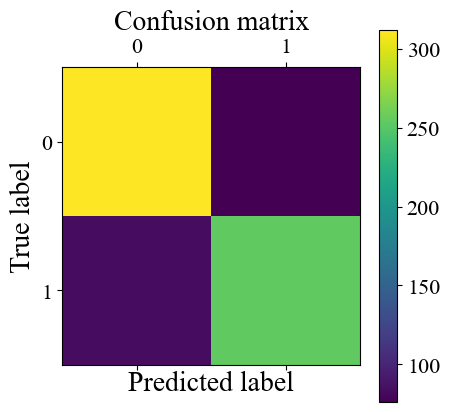

In [23]:
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif']=['Times New Roman']
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)
plt.matshow(confusion_matrix)
plt.title('Confusion matrix',fontsize = 20)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=16)
plt.ylabel('True label', fontsize = 20)
plt.xlabel('Predicted label',fontsize = 20)
plt.savefig('c2.png', dpi = 300)
#plt.show()

In [18]:
#from sklearn.inspection import plot_partial_dependence
table = pd.crosstab(y_test, y_pred, rownames = ['Actual'], colnames = ['Predicted'])
table

Predicted,False,True
Actual,,
False,312,76
True,84,254


In [19]:
table = np.array(table)
Accuracy = (table[0, 0] + table[1,1]) /np.sum(table)
print(Accuracy)

Error_rate = 1 - Accuracy
print(Error_rate)

0.7796143250688705
0.22038567493112948


In [20]:
Precision = table[1, 1]/(table[1, 1]+table[0, 1])
print('Precision:', Precision)

Sensitivity = table[1, 1]/(table[1, 0] + table[1,1])
print(Sensitivity)

Specificity = table[0, 0] /(table[0,0] + table[0, 1])
print(Specificity)

Recall = table[1, 1] /(table[0, 1] + table[1,1])
print(Recall)

print(f1_score(y_test, y_pred))
cohen_kappa_score(y_test, y_pred)

Precision: 0.7696969696969697
0.7514792899408284
0.8041237113402062
0.7696969696969697
0.7604790419161677


0.5564516129032258

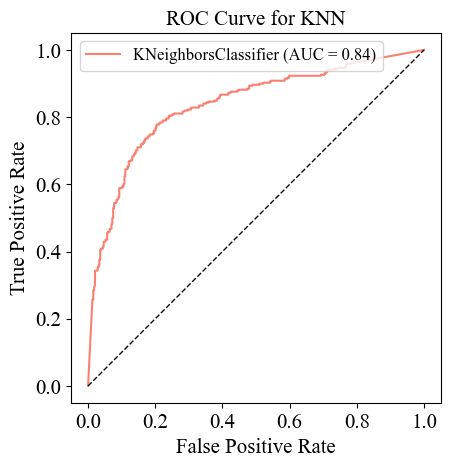

In [26]:
from sklearn.metrics import RocCurveDisplay
plt.rcParams['font.sans-serif']=['Times New Roman']

RocCurveDisplay.from_estimator(model_knn, X_test, y_test, color = 'salmon')
x = np.linspace(0, 1, 100)
plt.plot(x, x, 'k--', linewidth = 1)
plt.title('ROC Curve for KNN', fontsize = 15)
plt.axis('square')
plt.xlim()
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.xlabel('False Positive Rate', fontsize = 15)
plt.ylabel('True Positive Rate',fontsize = 15)
fontdict = {'family': 'Times New Roman',
            'size': 12}
            #'style': 'italic'}
plt.legend(prop=fontdict, loc = 'upper left')
plt.savefig('r2.png', dpi = 300)
#plt.show()

In [ ]:
df_ex = pd.read_csv('testset0.csv', index_col = 0)
df_ex.head(2)

In [ ]:
df_ex['Magmom'] = df_ex['Magmom'].round(3)
df_ex.head(2)

In [ ]:
df_ex = StrToComposition().featurize_dataframe(df_ex, 'Formula')
df_ex = CompositionToOxidComposition().featurize_dataframe(df_ex, 'composition')
df_ex = OxidationStates().featurize_dataframe(df_ex, 'composition_oxid')
ep_feat = ElementProperty.from_preset(preset_name='magpie')
df_ex = ep_feat.featurize_dataframe(df_ex, col_id = 'composition')
df_ex.head()

In [ ]:
excluded = ['Formula', 'Magmom', 'composition', 'composition_oxid', 'Magnetic']
X_validation = df_ex.drop(excluded, axis = 1)
X_validation
y_validation = df_ex['Magnetic'].values

In [ ]:
y_predv = model_knn.predict(X_validation)
y_predv